In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn
import seaborn as sns
sns.set_theme(style='white')
import warnings
warnings.filterwarnings("ignore")

## 1. Data load, investigation and preparation

**Data Source:** https://www.cis.fordham.edu/wisdm/dataset.php

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Mounted at /content/drive
Hello Google Drive!

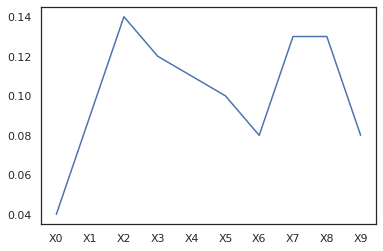

In [ ]:
#visalize x,y and z axis for single series
df = pd.read_csv('drive/My Drive/Boston University /CS677_Python/Project/WISDM_ar_v1.1_transformed.csv')
series=df[['UNIQUE_ID', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
       'X8', 'X9', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
       'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9','user','class']].iloc[0]

plt.plot(series[1:11])

In [ ]:
# Read data
df = pd.read_csv('drive/My Drive/Boston University /CS677_Python/Project/WISDM_ar_v1.1_transformed.csv')
df=df.set_index('UNIQUE_ID')
df=df.rename(columns={'class':'Activity'})
df.user=df.user.astype('str')
df=df[['XAVG','YAVG','ZAVG','XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'RESULTANT','user', 'Activity']]
df=df.replace('?',np.NaN)
df=df.dropna(axis=0) #remove missing values
df.tail(2)

,XAVG,YAVG,ZAVG,XPEAK,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,user,Activity
UNIQUE_ID,,,,,,,,,,,,,,,
362,0,8.30,-0.24,2216.67,535.29,1383.33,4.54,4.47,3.27,5.65,5.51,5.65,10.97,19,Downstairs
363,0,8.03,-0.16,1750,625,3475,5.36,4.83,3.22,6.80,5.68,6.80,11.31,19,Downstairs


# 2.Exploratory Data Analysis

In [ ]:
activity_count=pd.DataFrame(df.Activity.value_counts())
fig=px.pie(activity_count,names=activity_count.index,values='Activity',
           title='% Share of Activity Classes in Target Variable',height=400,width=600,
           color_discrete_sequence=px.colors.sequential.RdBu)

fig.show()

In [ ]:
user_count=pd.DataFrame(df.user.value_counts())
fig=px.pie(user_count,names=user_count.index,values='user',
           title='% Share of samples by test subject',height=400,width=600,
           color_discrete_sequence=px.colors.sequential.RdBu)

fig.show()

**Finding:** Target Classes are not balanced, this will be addressed with randomized over-sampling during model training

In [ ]:
px.box(df,y='YPEAK',x='Activity',title='YPEAK',height=400,width=600)

In [ ]:
px.box(df,y='YABSOLDEV',x='Activity',title='YABSOLDEV',height=400,width=600)

In [ ]:
px.box(df,y='XSTANDDEV',x='Activity',title='XSTANDDEV',height=400,width=600)

In [ ]:
px.box(df,y='YAVG',x='Activity',title='YAVG',height=400,width=600)

In [ ]:
#dimensionality reduction using PCA and tSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances

df2 = df.drop(columns=['Activity','user'],axis=1).copy()

scaler=StandardScaler()
scaled=scaler.fit_transform(df2)

pca=PCA(n_components=2,random_state=3)
reduced=pca.fit_transform(scaled)
scaled_pca=scaler.fit_transform(reduced)

pca_data=pd.DataFrame(scaled_pca,df.Activity).reset_index()
pca_data
px.scatter(pca_data,x=0,y=1,color='Activity',
           height=600,width=800,title='Two dimensional Principle Component Analysis by Activity')

In [ ]:
#calculate silhouette_score for with all features
labels = pca_data.Activity
X = pca_data[[0,1]]
total_ch=metrics.silhouette_score(X, labels, metric='euclidean')

#calculte silhouette_score when dropping one feature
CH_index = pd.DataFrame(columns=['feature dropped','new_silhouette_score'])
for i in pca_data.Activity.unique():
  subset=pca_data[pca_data.Activity != i]
  labels = subset.Activity
  X = subset[[0,1]]
  ch=metrics.silhouette_score(X, labels, metric='euclidean')
  CH_index=CH_index.append({'feature dropped':i,'new_silhouette_score':ch},ignore_index=True)
CH_index

#assess distance
CH_index['change'] =  round((CH_index['new_silhouette_score'] - total_ch),3)
CH_index

,feature dropped,new_silhouette_score,change
0,Jogging,-0.013820,-0.056
1,Walking,0.140712,0.098
2,Upstairs,0.075207,0.033
3,Downstairs,0.107122,0.065
4,Sitting,0.040092,-0.002
5,Standing,0.053356,0.011


In [ ]:
pca_data=pd.DataFrame(scaled_pca,df.user).reset_index()
pca_data
px.scatter(pca_data,x=0,y=1,color='user',
           height=600,width=800,title='Two dimensional Principle Component Analysis by User')

**Finding:** The PCA analysis shows that some classes are easier to distinguish than others (e.g. Walking, Sitting and Standing). The ones that are easiers to distinguish are expected to also have a greater accuarcy.

# 3. Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

y = df.Activity
x = df.drop(['Activity','user'],axis=1)

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,random_state=0,stratify=y)

# 4. Model Selection and Evaluation

## 4.1 Define method to find optimal number of features & calculate classification report

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import RandomOverSampler

#retrun accuracies for changing size of feature subsets, receive model type as input
def getAccuracies(model):
  accuracies = []
  for i in range(1,len(df.columns)-1):
    pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                           ('feature_selection',SelectKBest(f_classif, k=i)),
                         ('sampling', RandomOverSampler(random_state=100)),
                        ('model', model)
                             ])
    pipe.fit(X_train,y_train)
    preds=pipe.predict(X_valid)
    accuracy = accuracy_score(preds,y_valid)
    accuracies.append([i,accuracy])
  accuracies=pd.DataFrame(accuracies,columns=['n_Features','Accuracy_Score'])
  fig=px.line(accuracies,x='n_Features',y='Accuracy_Score',height=400,width=800,
              title='Accuracy with changing number of selected features')
  return accuracies

#retrain model with optimal number of features (k)
def getPerformanceReport(model,i): 
  pipe = Pipeline(steps=[('feature_selection',SelectKBest(f_classif, k=i)),
                         ('sampling', RandomOverSampler(random_state=100)),
                        ('model', model)
                             ])
  pipe.fit(X_train,y_train)
  preds=pipe.predict(X_valid)
  accuracy=accuracy_score(y_valid,preds)
  accuracies.append([i,accuracy])
  return classification_report(y_valid,preds)

## 4.2 Modelling

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC

#define models
tree_model = DecisionTreeClassifier(random_state=0)
random_forest_model = RandomForestClassifier(random_state=0, n_estimators=100,criterion='gini',max_leaf_nodes=None)
n_bayes_model = GaussianNB()
LR_model = LogisticRegression()
xgb_clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,random_state=0,n_iter_no_change=5)
svc=SVC()

#calculate accuracy for each subset of k features
tree_accuracies=getAccuracies(tree_model)
rf_accuracies=getAccuracies(random_forest_model)
nb_accuracies=getAccuracies(n_bayes_model)
lr_accuracies=getAccuracies(LR_model)
xgb_accuracies=getAccuracies(xgb_clf)
svc_accuracies=getAccuracies(svc)

accuracies = [tree_accuracies,rf_accuracies,nb_accuracies,lr_accuracies,xgb_accuracies,svc_accuracies]

In [ ]:
import plotly.graph_objects as go

x_axis = np.arange(1,14)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=tree_accuracies.Accuracy_Score,
                    mode='lines+markers',
                    name='DecisionTree'))
fig.add_trace(go.Scatter(x=x_axis, y=rf_accuracies.Accuracy_Score,
                    mode='lines+markers',
                    name='RandomForest'))
fig.add_trace(go.Scatter(x=x_axis, y=nb_accuracies.Accuracy_Score,
                    mode='lines+markers',
                    name='Gaussian Naïve Bayes'))
fig.add_trace(go.Scatter(x=x_axis, y=lr_accuracies.Accuracy_Score,
                    mode='lines+markers',
                    name='Logistic Regression'))
fig.add_trace(go.Scatter(x=x_axis, y=xgb_accuracies.Accuracy_Score,
                    mode='lines+markers',
                    name='Gradient Boost XGB'))
fig.add_trace(go.Scatter(x=x_axis, y=svc_accuracies.Accuracy_Score,
                    mode='lines+markers',
                    name='Support Vector'))
fig.update_layout(title='Accuarcy Score with increasing number of features by Classifier',
                   xaxis_title='#Features',
                   yaxis_title='Accuracy Score',
                  height=500,width=800)
fig.show()

In [ ]:
print(getPerformanceReport(random_forest_model,9))

              precision    recall  f1-score   support

  Downstairs       0.73      0.79      0.76       101
     Jogging       0.98      0.98      0.98       323
     Sitting       0.96      1.00      0.98        27
    Standing       1.00      0.87      0.93        15
    Upstairs       0.83      0.70      0.76       117
     Walking       0.93      0.96      0.94       406

    accuracy                           0.92       989
   macro avg       0.91      0.88      0.89       989
weighted avg       0.91      0.92      0.91       989



In [ ]:
#evaluate - Selected K-Best 
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train)


selector=SelectKBest(f_classif, k=len(X_train.columns))
selector.fit_transform(scaled_df,y_train),
anova=pd.DataFrame(selector.scores_,index=X_train.columns).sort_values(by=0,ascending=False).iloc[:len(X_train.columns)]
anova=anova.reset_index()
anova=anova.rename(columns={'index':'Feature',0:'F-Test'})
fig = px.bar(anova, x='Feature', y='F-Test',
             title='Feature Selection based on ANOVA F-Test (SelectKBest)',
             height=400,width=800)
fig.update_traces(marker_color='lightsalmon')
fig.show() 